# Прогнозирование октановых чисел RON и MON для индивидуальных веществ

**RON** (Research Octane Number) и **MON** (Motor Octane Number) - это два важных параметра, используемые для характеристики качества и октанового числа бензина. Они имеют большое значение в нефтяной промышленности и автомобильной индустрии. Определение RON и MON важно по слелующим причинам:

* Эффективность двигателя и мощность

* Предотвращение детонации

* Защита окружающей среды

* Совместимость и смешиваемость

* Экономические аспекты

Данные характеристики часто измеряют экспериментально, существуют стандарты по которым определяют значение октановых чисел. Однако из различных соображений (экономичекая эффективность или оценка новых соединений), прогнозирование октановых чисел является актуальной задачей.

## Подготовка датасета. Статистика и анализ

### Данные
Значения октановых чисел для различных соединений собирались по нескольким источникам:
1. https://www.kaggle.com/datasets/saurabhshahane/prediction-of-octane-sensitivity-ron-mon

2. https://www.nrel.gov/transportation/fuels-properties-database/

3. doi:10.1080/10916466.2015.1050506 

4. https://doi.org/10.1021/acs.energyfuels.0c01533

    Данные брались исключительно экспериментальные, без прогнозов.

    Октановые числа были собраны в файл **data.csv**. Название веществ, их классы и смайлы находились в колонках Name, Fuelclass, Smiles соответственно

    
    Далее значения октановых чисел RON & MON приведены в следующем формате:
   
*Столбец (char_id), где char = {RON,MON}, id = {1,2,3,4} показывает, что значение параметра char было взято из источника id (id равен номеру списка источников сверху)*

---

    При составлении своей маленькой базы данных проделано следующее:

*1)* Названия веществ находились в различном формате. Чаще всего было дано одно из возможных названий вещества без (кодировки smiles) и его октановые числа. Сопостановление названию вещества его смайлсу проходило в ручном режиме через базу данных [PubChem](https://pubchem.ncbi.nlm.nih.gov/).

*2)* В некоторых источников не было указаны цис- транс- изомерии олефинов. Если в каком-то другом источнике для какого-то вещества указана его геометрическая изомерия и даны значения RON/MON, то при совпадении этих значений с значениями неопределенного (по цис-транс геометрии) алкена, для неопределенного алкена ставилась конфигурация помеченного алкена и менялся smiles добавлением символов / или \ . <br>Если во всех источниках не указана конфигурация, то smiles алкена оставался без учета конфигурации.

*3)* Для обнаружения одинаковых соединений использовалась канонизация smiles. Значение MON и RON копировались из дубликата и добавлялись в соответствующую колонку оригинала. Дубликат удалялся

*4)* При большом разбросе значений октановых чисел были изменены некоторые (RON/MON)_id. Замена происходила из следующих соображений:

* Сравнились все значения с значением из 5-го источника https://doi.org/10.2172/1291241

* Если какое-то значение доминировало количественно над другим (3 vs 1), то последнее изменялось на доминантное значение

* Если доминантных значений нет, то октановые числа соединения сравнивались с октановыми числами похожих соединений (например бутанол-2 и пентанол-2). Далее ((из химических соображений)) делался вывод о правдоподобности значений октановых чисел

* Если вещество не удавалось сравнить с другими соединениями и его октановые числа были разбросаны на большом промежутке числовой прямой, то соединение удалялось. Также удалялись соедининия с значениями октановых чисел сильно >120

Подробно о том какие значения менялись записано в файле **description.txt**.

Разброс октановых чисел соединений оценивался с помощью дисперсии. Если дисперсия >=25, то проводился анализ соединения по методике выше.

---

Импорт нужных пакетов для анализа

In [76]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from rdkit import Chem

### Сохраните все файлы в текущую директорию где запущен ноутбук (или измените переменную data_root на путь куда сохранены мои csv файлы)

In [77]:
from pathlib import Path
data_root = Path('.')

Записываем в переменную df собранные данные 

In [78]:
df = pd.read_csv(data_root / 'data.csv',delimiter=';')
df.head(6)

,Name,Fuelclass,Smiles,RON_1,MON_1,RON_2,MON_2,RON_3,MON_3,RON_4,MON_4
0,Methanol,Alcohols,CO,108.7,88.6,NaN,NaN,NaN,NaN,110.0,87.0
1,Ethanol,Alcohols,CCO,109.0,90.0,109.0,89.0,NaN,NaN,109.0,90.0
2,1-Propanol,Alcohols,CCCO,104.0,89.0,104.0,89.0,NaN,NaN,102.6,98.0
3,2-Propanol,Alcohols,CC(C)O,106.0,99.0,112.5,96.7,NaN,NaN,106.0,99.0
4,1-Butanol,Alcohols,CCCCO,98.0,85.0,98.0,85.0,NaN,NaN,98.0,85.0
5,2-Butanol,Alcohols,CCC(C)O,105.0,93.0,107.0,93.0,NaN,NaN,105.0,93.0


Делаем канонизацию всех smiles и выводим дубликаты

In [79]:
df['Smiles'] = df['Smiles'].apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x)) if pd.notna(x) else x)
duplicates = df[df.duplicated(subset='Smiles', keep=False)]
duplicates

,Name,Fuelclass,Smiles,RON_1,MON_1,RON_2,MON_2,RON_3,MON_3,RON_4,MON_4
28,n-Heptane,Alkanes,CCCCCCCC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
68,n-Octane,Alkanes,CCCCCCCC,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
78,2-Pentene,Alkenes,CC=CCC,NaN,NaN,NaN,NaN,NaN,NaN,87.8,87.8
97,4-Methyl-2-pentene (cis),Alkenes,C/C=C\C(C)C,99.3,84.3,NaN,NaN,98.9,85.1,99.7,84.5
98,2-Ethyl-1-butene,Alkenes,C/C=C\C(C)C,98.3,79.4,NaN,NaN,NaN,NaN,98.3,79.4
112,3-Methyl-3-hexene (cis),Alkenes,CC/C=C(\C)CC,NaN,NaN,NaN,NaN,NaN,NaN,96.0,81.4
114,3-Methyl-3-hexene (trans),Alkenes,CC/C=C(\C)CC,96.4,81.4,NaN,NaN,NaN,NaN,96.4,81.6
149,2-Pentene,Alkenes,CC=CCC,NaN,NaN,90.0,77.2,87.8,87.8,NaN,NaN
307,Dipentene,Cycloalkenes,C=C(C)C1CC=C(C)CC1,NaN,NaN,NaN,NaN,NaN,NaN,90.6,73.2
309,LIMONENE,Cycloalkenes,C=C(C)C1CC=C(C)CC1,NaN,NaN,87.1,NaN,NaN,NaN,NaN,NaN


Заменяем пустые значения на np.nan, считаем дисперсию MON и RON для каждого соединения

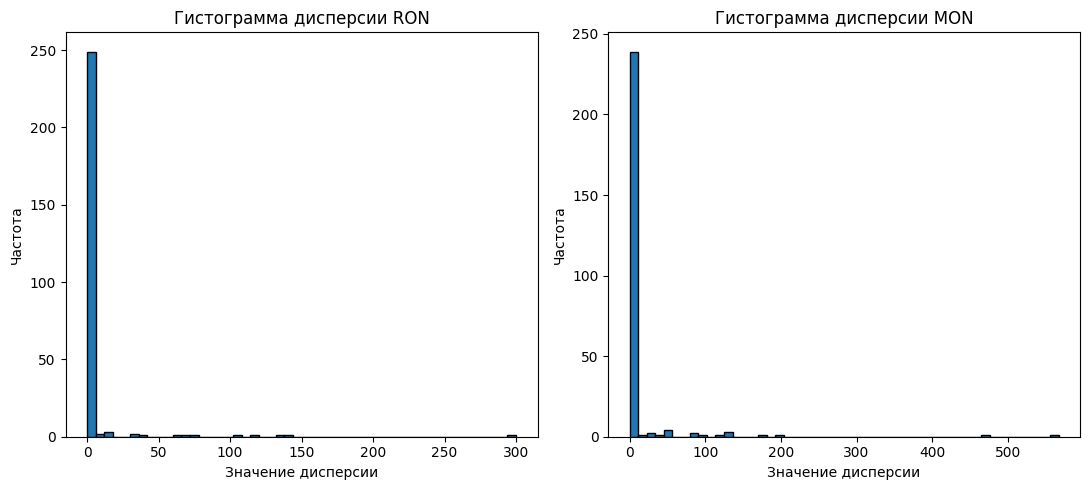

Всего 11 соединений с дисперсией RON свыше 25
Всего 18 соединений с дисперсией MON свыше 25


In [80]:
df = df.replace('None', np.nan)
df['Dispersions_RON'] = df[['RON_1', 'RON_2', 'RON_3', 'RON_4']].astype(float).var(axis=1, skipna=True)
df['Dispersions_MON'] = df[['MON_1', 'MON_2', 'MON_3', 'MON_4']].astype(float).var(axis=1, skipna=True)

fig, axes = plt.subplots(1, 2, figsize=(11, 5))

# Гистограмма для дисперсии RON

axes[0].hist(df['Dispersions_RON'], bins=50, edgecolor='k')
axes[0].set_xlabel('Значение дисперсии')
axes[0].set_ylabel('Частота')
axes[0].set_title('Гистограмма дисперсии RON')

# Гистограмма для дисперсии MON

axes[1].hist(df['Dispersions_MON'], bins=50, edgecolor='k')
axes[1].set_xlabel('Значение дисперсии')
axes[1].set_ylabel('Частота')
axes[1].set_title('Гистограмма дисперсии MON')
plt.tight_layout()
plt.show()

count_RON = len(df[df['Dispersions_RON'] >= 25])
count_MON = len(df[df['Dispersions_MON'] >= 25])
print(f'Всего {count_RON} соединений с дисперсией RON свыше 25')
print(f'Всего {count_MON} соединений с дисперсией MON свыше 25')

Выводим соединения с дисперсией > 25

In [81]:
disp_RON = df[df['Dispersions_RON'] > 25][['Name','Dispersions_RON']].reset_index(drop=True)
disp_MON = df[df['Dispersions_MON'] > 25][['Name','Dispersions_MON']].reset_index(drop=True)

disp_RON,disp_MON

(                         Name  Dispersions_RON
 0          2-Methyl-2-butanol        65.333333
 1      2,2,3-Trimethylpentane        31.363333
 2            4-Octene (trans)       114.510000
 3         1,2-Dimethylbenzene        75.000000
 4         1,3-Dimethylbenzene       104.083333
 5         1,4-Dimethylbenzene       139.720000
 6                     Benzene       300.000000
 7             n-Propylbenzene       132.062500
 8           iso-Propylbenzene        39.970000
 9      1,3,5-Trimethylbenzene        70.580000
 10  2-Methoxy-2-methylpropane        34.445000,
                           Name  Dispersions_MON
 0                   1-Propanol        27.000000
 1                    1-Hexanol        96.605000
 2                      Propene        43.245000
 3                     2-Butene        89.653333
 4        3,3-Dimethyl-1-butene        84.640000
 5            2-Methyl-1-hexene        26.645000
 6            4-Methyl-1-hexene        50.000000
 7            5-Methyl-1-hexene

После очистки датасета, он был записал в файл **data_fixed.csv** 

In [82]:
df_fixed = pd.read_csv(data_root / 'data_fixed.csv',delimiter=';')
df_fixed = df_fixed.replace('None', np.nan)
df_fixed['Dispersions_RON'] = df_fixed[['RON_1', 'RON_2', 'RON_3', 'RON_4']].astype(float).var(axis=1, skipna=True)
df_fixed['Dispersions_MON'] = df_fixed[['MON_1', 'MON_2', 'MON_3', 'MON_4']].astype(float).var(axis=1, skipna=True)
count_RON = len(df_fixed[df_fixed['Dispersions_RON'] >= 25])
count_MON = len(df_fixed[df_fixed['Dispersions_MON'] >= 25])
num_rows = len(df_fixed)

print(f'Всего {count_RON} соединений с дисперсией RON свыше 25')
print(f'Всего {count_MON} соединений с дисперсией MON свыше 25')
print(f'Количество соединений в датасете {num_rows}')

Всего 0 соединений с дисперсией RON свыше 25
Всего 0 соединений с дисперсией MON свыше 25
Количество соединений в датасете 355


Запишем в новый датафрейм *df_final* значения smiles молекул и соответствующие RON и MON как средние значение {char_id}.

In [83]:
df_final = pd.DataFrame()

df_final['Smiles'] = df_fixed['Smiles']
df_final['RON'] = df_fixed[['RON_1', 'RON_2', 'RON_3', 'RON_4']].mean(axis=1)
df_final['MON'] = df_fixed[['MON_1', 'MON_2', 'MON_3', 'MON_4']].mean(axis=1)

# Запись в CSV файл
#df_final.to_csv(data_root / 'data_final.csv', index=False, sep=';')
df_final.head()

,Smiles,RON,MON
0,CO,109.350000,87.800000
1,CCO,109.000000,89.666667
2,CCCO,103.533333,89.000000
3,CC(C)O,108.166667,98.233333
4,CCCCO,98.000000,85.000000


Нарисуем красивых картиночек Distribution & Quantile-Quantile plot

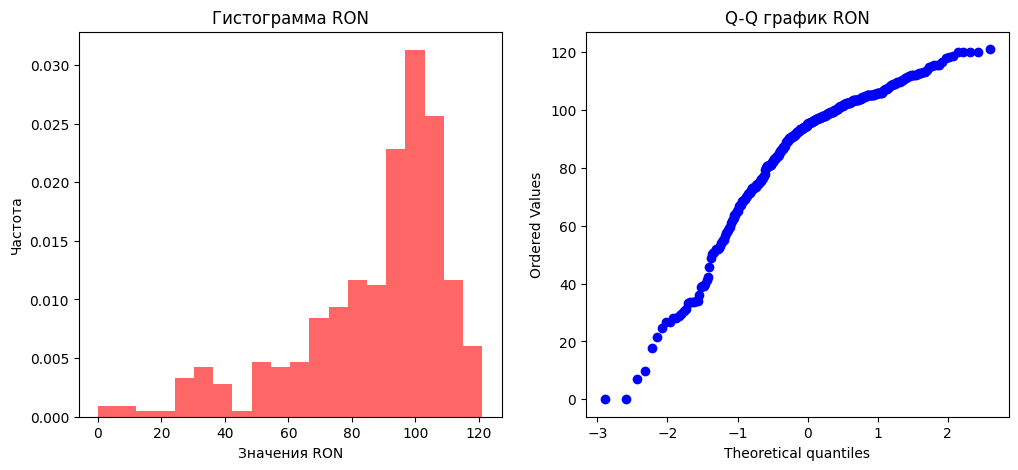

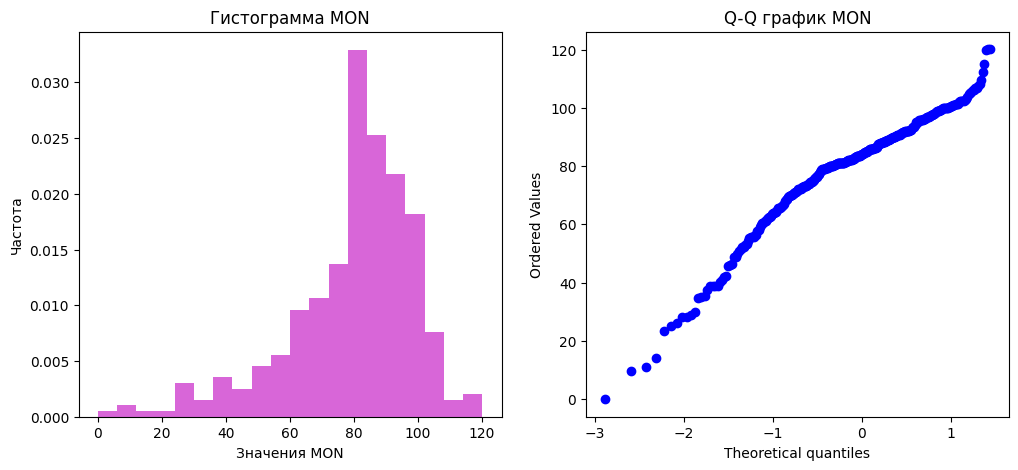

In [84]:
import scipy.stats as stats

# Гистограмма RON
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(df_final['RON'], bins=20, density=True, alpha=0.6, color='r')
plt.xlabel("Значения RON")
plt.ylabel("Частота")
plt.title('Гистограмма RON')

# Q-Q график RON
plt.subplot(1, 2, 2)
stats.probplot(df_final['RON'], dist="norm", plot=plt)
plt.title('Q-Q график RON')

plt.show()

# Гистограмма MON
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(df_final['MON'], bins=20, density=True, alpha=0.6, color='m')
plt.xlabel("Значения MON")
plt.ylabel("Частота")
plt.title('Гистограмма MON')

# Q-Q график MON
plt.subplot(1, 2, 2)
stats.probplot(df_final['MON'], dist="norm", plot=plt)
plt.title('Q-Q график MON')

plt.show()


## ML

### Выбор дескрипторов

 В качестве дескрипторов молекул были выбраны fingerprints **Avalon** и дескрипторы из **RDKit** (209 признаков). Аналогом Avalon рассматривались структурные ключи **MACCS** и fingerprints **ECFP**. MACCS ключи проигрывали Avalon отпечаткам (возможно из-за того что MACCS ключи плохо описавают мои молекул). Выбор между ECFP и Avalon происходил исходя из значений MAE для разных *random_state* . Лучше себя показали Avalon отпечатки. Поэтому в качетсве дескрипторов, описывающие топологию/граф молекулы, выбранны именно эти отпечатки.

Из дескрипторов, описывающих свойства молекул, были выбраны на рассмотрение дескрипторы из RDKit и **Mordred**. Значение метрики при разные random_state было примерно одинаковым для данных дескрипторов, однако в качестве основных были выбраны дескрипторы RDKit ввиду того что:

* Они уже доказали свою эффективность в других работах
* При меньшем количестве бит в векторе (209 vs 1613) метрика была почти равная
* Важность фичей (feature importance) для RDKit интерпретируется лучше чем для Mordred (SHAP values) 


<div style="display: flex;">
  <div style="flex: 50%; padding: 10px;">
    <img src="https://chemicbook.com/_images/circled-atoms-benzamide.png" alt="Изображение 1">
  </div>
  <div style="flex: 50%; padding: 10px;">
    <img src="https://www.rdkit.org/docs/_static/logo.png" alt="Изображение 2">
  </div>
</div>

Написанная ниже функция <span style="color:blue">get_morgan_fingerprints_and_descriptors</span> принимает на вход датафрейм <span style="color:red">df</span> с указанием столбца <span style="color:red">smiles_column</span>, содержащий smiles молекул и дает на выход матрицу признаков, содержащая бинарные столбцы в количестве равным входным <span style="color:red">nBits</span> (было выбрано 1024 бит) и векторы дескрипторов молекул из RDKit (209 столбцов).Есть возможность включить остальные фичи, по умолчанию они отключены.

In [85]:
# Импорт нужных библиотек для создания фичей
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Avalon import pyAvalonTools
from rdkit.Chem import MACCSkeys
from mordred import Calculator, descriptors

In [86]:
# Функция для создания матрицы молекулярных отпечатков и дескрипторов
# MACCS, ECFP, Mordred desc выключены
def get_morgan_fingerprints_and_descriptors(df, 
                                            smiles_column,
                                            ecfp = False,         # ECFP отпечатки выключены
                                            avalon = True,        # Avalon отпечатки включены
                                            calc_rdkit = True,    # RDKit дескриторы включены
                                            calc_mordred = False, # Mordred дескриторы выключены
                                            maccs_keys = False,   # MACCS ключи выключены
                                            radius=2, 
                                            nBits=1024):
    
    features_list = [] # Лист фичей

    for smiles in df[smiles_column]:
        mol = Chem.MolFromSmiles(smiles)
        mol = Chem.AddHs(mol)
        if mol is not None:
            
            # Создаем вектор фичей для одного соединения
            combined_vector = []
            
            # Генерация молекулярного отпечатка ECFP
            if ecfp:
                ecfp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits)
                ecfp_vector = [int(bit) for bit in ecfp.ToBitString()]
                combined_vector.extend(ecfp_vector)
                
            # Генерация молекулярного отпечатка Avalon
            if avalon:
                avfpts_vector = pyAvalonTools.GetAvalonCountFP(mol,nBits)
                #avfpts_vector = [int(bit) for bit in avfpts.ToBitString()]
                combined_vector.extend(avfpts_vector)

            # Генерация молекулярных дескрипторов Mordred
            if calc_mordred:
                calc_mordred = Calculator(descriptors, ignore_3D=True)
                descriptors_mordred = calc_mordred(mol)
                combined_vector.extend(descriptors_mordred)
            
            # Генерация молекулярных дескрипторов RDKit
            if calc_rdkit:
                calc_RDKit = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
                descriptors_RDKit = calc_RDKit.CalcDescriptors(mol)
                combined_vector.extend(descriptors_RDKit)

            # Генерация MACCS ключей
            if maccs_keys:
                maccs_keys = MACCSkeys.GenMACCSKeys(mol)
                maccs_vector = [int(bit) for bit in maccs_keys.ToBitString()]
                combined_vector.extend(maccs_vector)

            
            # Добавляем фичи соединения в матрицу фичей
            features_list.append(combined_vector)
            
        else:
            # Если молекула не удалась, добавляем пустой список
            features_list.append([])

    # Преобразуем список фичей в массив NumPy
    features_array = np.array(features_list)
    
    return features_array

Запись фичей в features_RON и features_MON (матрицы имеют разный размер, ибо для некоторых молекул нет данных по RON/MON)

In [87]:
df_filtered_RON = df_final.dropna(subset=['RON'])
features_RON = get_morgan_fingerprints_and_descriptors(df_filtered_RON, 'Smiles')

df_filtered_MON = df_final.dropna(subset=['MON'])
features_MON = get_morgan_fingerprints_and_descriptors(df_filtered_MON, 'Smiles')

print(features_RON.shape)
print(features_MON.shape)

(354, 1233)
(329, 1233)


### Разбиение данных 
Все данные были разбиты на тренировочный (train), валидационный (valid) и тестовый (test) наборы в соотношении 70:15:15

In [88]:
from sklearn.model_selection import train_test_split

# Наборы для RON
X_train_RON, X_temp_RON, y_train_RON, y_temp_RON = train_test_split(
    features_RON,  # Fingerprints and descriptors RDKit
    df_filtered_RON['RON'].to_numpy(),  # Target
    test_size=0.3,  # Доля тестового набора (30%)
    random_state=66  # Задайте seed для воспроизводимости
)

X_valid_RON, X_test_RON, y_valid_RON, y_test_RON = train_test_split(
    X_temp_RON, 
    y_temp_RON, 
    test_size=0.5, 
    random_state=616
)

#-------------------------------------------------------------------

# Наборы для MON
X_train_MON, X_temp_MON, y_train_MON, y_temp_MON = train_test_split(
    features_MON,  # Fingerprints and descriptors RDKit
    df_filtered_MON['MON'].to_numpy(),  # Target
    test_size=0.3,  # Доля тестового набора (30%)
    random_state=66 # Задайте seed для воспроизводимости
)

X_valid_MON, X_test_MON, y_valid_MON, y_test_MON = train_test_split(
    X_temp_MON, 
    y_temp_MON, 
    test_size=0.5, 
    random_state=616
)


Вывод информации о классе и размере различных наборов датасета

In [89]:
a = type(X_train_RON),type(X_test_RON),type(X_valid_RON),type(y_train_RON),type(y_test_RON),type(y_valid_RON)
b = X_train_RON.shape, X_test_RON.shape, X_valid_RON.shape, y_train_RON.shape, y_test_RON.shape, y_valid_RON.shape
c = 'X_train_RON', 'X_test_RON', 'X_valid_RON', 'y_train_RON', 'y_test_RON', 'y_valid_RON'
for i in range(6):
    print(f'Тип набора {c[i]}:\t {a[i]}\tРазмер:{b[i]}')
print('--------------------------------------------------------------------------')    
a = type(X_train_MON),type(X_test_MON),type(X_valid_MON),type(y_train_MON),type(y_test_MON),type(y_valid_MON)
b = X_train_MON.shape, X_test_MON.shape, X_valid_MON.shape, y_train_MON.shape, y_test_MON.shape, y_valid_MON.shape
c = 'X_train_MON', 'X_test_MON', 'X_valid_MON', 'y_train_MON', 'y_test_MON', 'y_valid_MON'
for i in range(6):
    print(f'Тип набора {c[i]}:\t {a[i]}\tРазмер:{b[i]}')

Тип набора X_train_RON:	 <class 'numpy.ndarray'>	Размер:(247, 1233)
Тип набора X_test_RON:	 <class 'numpy.ndarray'>	Размер:(54, 1233)
Тип набора X_valid_RON:	 <class 'numpy.ndarray'>	Размер:(53, 1233)
Тип набора y_train_RON:	 <class 'numpy.ndarray'>	Размер:(247,)
Тип набора y_test_RON:	 <class 'numpy.ndarray'>	Размер:(54,)
Тип набора y_valid_RON:	 <class 'numpy.ndarray'>	Размер:(53,)
--------------------------------------------------------------------------
Тип набора X_train_MON:	 <class 'numpy.ndarray'>	Размер:(230, 1233)
Тип набора X_test_MON:	 <class 'numpy.ndarray'>	Размер:(50, 1233)
Тип набора X_valid_MON:	 <class 'numpy.ndarray'>	Размер:(49, 1233)
Тип набора y_train_MON:	 <class 'numpy.ndarray'>	Размер:(230,)
Тип набора y_test_MON:	 <class 'numpy.ndarray'>	Размер:(50,)
Тип набора y_valid_MON:	 <class 'numpy.ndarray'>	Размер:(49,)


### Модели

В качестве основной модели была выбрана CatBoost, на основе градиентного бустинга с использованием ансаблей деревьев решений.

Дополнительной моделью для сравнения была обычная модель случайного леса

Нейронные сети не рассматривались, ибо датасет слишком маленький для их обучения

In [90]:
# Импорт всех моделей
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor

### Оптимизация гиперпараметров

Для оптимизации гиперпараметров модели Catboost использовалась **OPTUNA** с использованием сэмплера **TPESampler** вместе с прунером **HyperbandPruner**. Была провеведена оптимизация количеств итераций, глубина деревьев, скорость обучения и коэффициент регуляризации L2.В частности L2 регуляризация может помочь предотвратить переобучение (надеюсь).
Оптимизацию гиперпараметров модели RandomForest можно сделать аналогично.
<div style="display: flex;">
  <div style="flex: 50%; padding: 10px;">
    <img src="https://raw.githubusercontent.com/optuna/optuna/master/docs/image/optuna-logo.png" alt="Изображение 1">

In [91]:
from catboost import Pool
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import HyperbandPruner

from sklearn.metrics import mean_absolute_error

In [92]:
# Создаем функцию, которую Optuna будет оптимизировать
def objective_RON(trial):
    # Параметры, которые будем оптимизировать
    params = {
        'iterations': trial.suggest_int('iterations', 500, 2000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 100),
    }

    # Создание модели CatBoostRegressor с определенными параметрами
    model_RON = CatBoostRegressor(
        **params,
        loss_function='MAE',  
        task_type='CPU',  # Если у вас есть GPU, включите его здесь
        verbose=0  # Чтобы подавить вывод
    )

    # Создание пулов для обучающих и валидационных данных
    train_pool = Pool(X_train_RON, y_train_RON)
    valid_pool = Pool(X_valid_RON, y_valid_RON)

    # Обучение модели
    model_RON.fit(train_pool, eval_set=valid_pool)

    # Получение прогнозов
    y_pred_RON = model_RON.predict(X_valid_RON)

    # Рассчитайтать метрику, которую мы хотим оптимизировать
    mae_RON = mean_absolute_error(y_valid_RON, y_pred_RON)

    return mae_RON

# Аналогичную функцию для MON значений

def objective_MON(trial):
    # Параметры, которые будем оптимизировать
    params = {
        'iterations': trial.suggest_int('iterations', 500, 2000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 100),
    }

    # Создайте модель CatBoostRegressor с определенными параметрами
    model_MON = CatBoostRegressor(
        **params,
        loss_function='MAE',  
        task_type='CPU',  # Если у вас есть GPU, включите его здесь
        verbose=0  # Чтобы подавить вывод
    )

    # Создание пулов для обучающих и валидационных данных
    train_pool = Pool(X_train_MON, y_train_MON)
    valid_pool = Pool(X_valid_MON, y_valid_MON)

    # Обучение модели
    model_MON.fit(train_pool, eval_set=valid_pool)

    # Получение прогнозов
    y_pred_MON = model_MON.predict(X_valid_MON)

    # Рассчитайтать метрику, которую мы хотим оптимизировать
    mae_MON = mean_absolute_error(y_valid_MON, y_pred_MON)

    return mae_MON

In [93]:
# Создает прунер и сэмплер
sampler = optuna.samplers.TPESampler()
pruner = optuna.pruners.HyperbandPruner()

# Создает объект Optuna и запускает оптимизацию для RON и MON
if 0: # Включите если хотите начать оптимизацию
    study_RON = optuna.create_study(sampler=sampler, pruner=pruner, direction='minimize') 
    study_RON.optimize(objective_RON, n_trials=100)  # Укажите желаемое количество пробных итераций

    study_MON = optuna.create_study(sampler=sampler, pruner=pruner, direction='minimize') 
    study_MON.optimize(objective_MON, n_trials=100)  # Укажите желаемое количество пробных итераций# Вывод лучших параметров

In [94]:
# Вывод лучших параметров
if 0:
    best_params_RON = study_RON.best_params
    best_params_MON = study_MON.best_params
    print("Лучшие параметры для RON:", best_params_RON)
    print("Лучшие параметры для MON:", best_params_MON)
#Лучшие параметры для RON: {'iterations': 785, 'depth': 6, 'learning_rate': 0.1990427808789135, 'l2_leaf_reg': 77.32059191421368}
#Лучшие параметры для MON: {'iterations': 1861, 'depth': 8, 'learning_rate': 0.02563978821447624, 'l2_leaf_reg': 38.94596590414931}

Данные параметры мы и будем использовать для обучения модели

In [95]:
# Создание и обучение модели CatBoostRegressor

#RON
model_CB_RON = CatBoostRegressor(iterations=800, depth=6, learning_rate=0.2, l2_leaf_reg=77, loss_function='MAE')
model_CB_RON.fit(X_train_RON, y_train_RON, eval_set=(X_valid_RON, y_valid_RON))
#MON
model_CB_MON = CatBoostRegressor(iterations=1900, depth=8, learning_rate=0.03,l2_leaf_reg=39, loss_function='MAE')
model_CB_MON.fit(X_train_MON, y_train_MON, eval_set=(X_valid_MON, y_valid_MON))

#Создание и обучение модели RandomForestRegressor

#RON
model_RF_RON = RandomForestRegressor(n_estimators=1000, random_state=666)  
model_RF_RON.fit(X_train_RON, y_train_RON)
#MON
model_RF_MON = RandomForestRegressor(n_estimators=1000, random_state=666)  
model_RF_MON.fit(X_train_MON, y_train_MON)


0:	learn: 14.4712305	test: 19.8690238	best: 19.8690238 (0)	total: 4.19ms	remaining: 3.35s
1:	learn: 13.1292357	test: 18.1946083	best: 18.1946083 (1)	total: 7.45ms	remaining: 2.97s
2:	learn: 11.5427469	test: 16.7964728	best: 16.7964728 (2)	total: 10.6ms	remaining: 2.81s
3:	learn: 10.8497545	test: 16.1348879	best: 16.1348879 (3)	total: 13.7ms	remaining: 2.72s
4:	learn: 10.4280881	test: 15.8329432	best: 15.8329432 (4)	total: 16.8ms	remaining: 2.66s
5:	learn: 9.7946539	test: 14.8883308	best: 14.8883308 (5)	total: 19.9ms	remaining: 2.63s
6:	learn: 9.4716423	test: 14.5685168	best: 14.5685168 (6)	total: 22.9ms	remaining: 2.6s
7:	learn: 8.9957895	test: 14.4639441	best: 14.4639441 (7)	total: 26ms	remaining: 2.57s
8:	learn: 8.6830720	test: 13.8755455	best: 13.8755455 (8)	total: 29.2ms	remaining: 2.57s
9:	learn: 8.5248789	test: 13.7946116	best: 13.7946116 (9)	total: 32.3ms	remaining: 2.55s
10:	learn: 8.1515408	test: 13.2579817	best: 13.2579817 (10)	total: 35.4ms	remaining: 2.54s
11:	learn: 7.6554

RandomForestRegressor(n_estimators=1000, random_state=666)

### Метрика

В качестве метрики была выбрана средняя абсолютная ошибка (Mean Absolute Error, MAE):

$\large \text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|$.


In [96]:
print('Значение метрики MAE для RON')
y_pred_CB_RON = model_CB_RON.predict(X_test_RON)
mae_CB_RON = mean_absolute_error(y_test_RON, y_pred_CB_RON)
print(f'CatBoostRegressor \tMAE: {mae_CB_RON}')

y_pred_RF_RON = model_RF_RON.predict(X_test_RON)
mae_RF_RON = mean_absolute_error(y_test_RON, y_pred_RF_RON)
print(f'RandomForestRegressor \tMAE: {mae_RF_RON}')

print('---------------------------------------------------')

print('Значение метрики MAE для MON')
y_pred_CB_MON = model_CB_MON.predict(X_test_MON)
mae_CB_MON = mean_absolute_error(y_test_MON, y_pred_CB_MON)
print(f'CatBoostRegressor \tMAE: {mae_CB_MON}')

y_pred_RF_MON = model_RF_MON.predict(X_test_MON)
mae_RF_MON = mean_absolute_error(y_test_MON, y_pred_RF_MON)
print(f'RandomForestRegressor \tMAE: {mae_RF_MON}')

Значение метрики MAE для RON
CatBoostRegressor 	MAE: 7.745775838008944
RandomForestRegressor 	MAE: 8.915256515652537
---------------------------------------------------
Значение метрики MAE для MON
CatBoostRegressor 	MAE: 4.919966770553921
RandomForestRegressor 	MAE: 6.1180119166666795


### Feature importance

Создание листа с именами фичей для отображения имен в **shap_plot**

In [97]:
#При включении дополнительных фичей цикл сломается :)
descriptor_names = [x[0] for x in Descriptors._descList]
feature_names = []

for i in range(features_MON.shape[1]):
    if i <1024:
        feature = f'Feature {i}'
        feature_names.append(feature)
    else:
        feature_names.append(descriptor_names[i-1024])

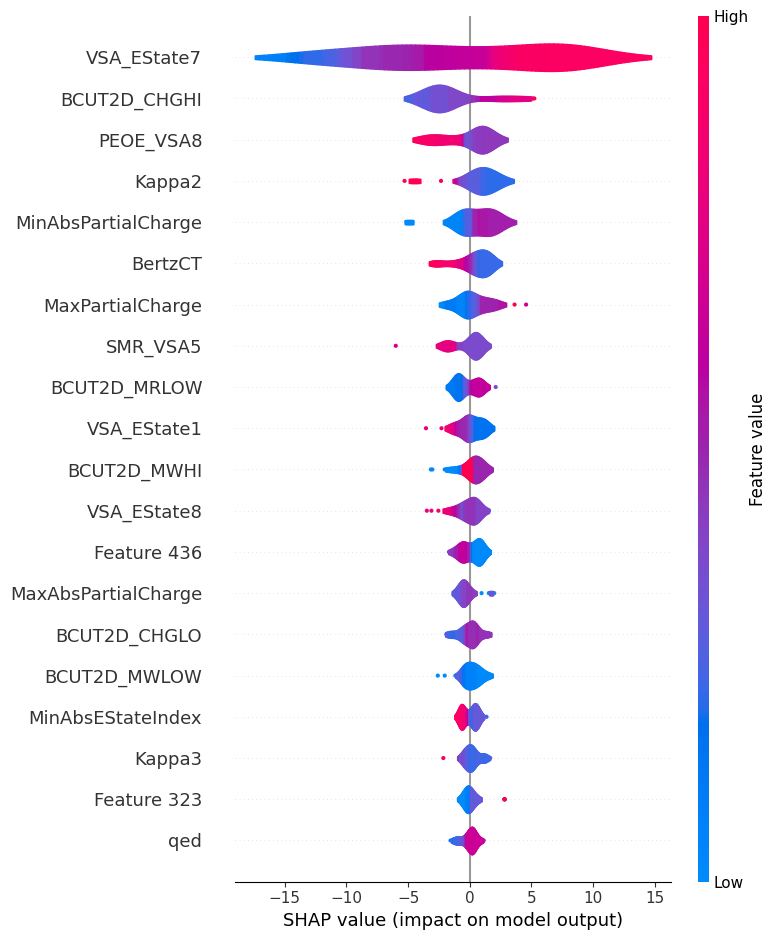

In [98]:
import shap
import warnings
# При включении Mordred дескрипторов shap_plot не сработает ввиду наличии nan значений в фичах
warnings.filterwarnings("ignore", category=UserWarning)
explainer = shap.Explainer(model_CB_RON)
shap_values = explainer.shap_values(X_test_RON)
shap.summary_plot(shap_values, 
                  X_test_RON, 
                  plot_type="violin",
                  feature_names=feature_names, 
                  color_bar=True)
warnings.resetwarnings()

Самые важные признаки, которые влияют на прогноз модели, рассчитаны с использованием значения Шепли.

Значительное влияние оказывают дескрипторы **VSA_EState7**,**BCUT2D_CHGHI**, **MinAbsPartialCharge**, **Kappa2**, **MaxPartialCharge**.
* Дескриптор VSA_EState7 рассчитывается как часть ван-дер-ваальсовой поверхности, при этом индекс EState электронотопологического состояния должен находиться в интервале 1,81-2,05.
* BCUT2D_CHGHI вычисляет инкремент заряда для каждого атома в молекуле на основе его химического окружения и топологии молекулы. Дескриптор также учитывает связи между атомами. Он анализирует, какие атомы связаны друг с другом и как электроны перемещаются через эти связи
* MinAbsPartialCharge представляет собой минимальное абсолютное значение частичного заряда (Partial Charge) среди всех атомов в молекуле.
* Kappa2 фокусируется на подсчете двойных связей внутри молекулы и учитывает кольцевые структуры в молекуле и их вклад в топологию.
* MaxPartialCharge относится к описанию максимальной частичной заряженности (partial charge) атомов в молекуле.

Можно сделать вывод, что на прогноз модели сильно влияет распределение зарядов в молекуле и количестве двойных связей/циклических структур.

## Обучение на 10 лучших признаках

Интересно было посмотреть, как модель CatBoost обучится на 10-ти лучших признаках.

Сначала получим индексы лучших признаков по матрице feature_RON/MON

In [99]:
import numpy as np

# Считаем средние абсолютные значения SHAP-значений для каждого признака
mean_abs_shap_values = np.mean(np.abs(shap_values), axis=0)

# Создали словарь где ключами будут индексы признаков, а значениями их средние абсолютные SHAP-значения
feature_importance_dict = {i: value for i, value in enumerate(mean_abs_shap_values)}

# Сортировка
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Топ 10 фичей
top_10_features = sorted_features[:10]
index_top_10 = [x[0] for x in top_10_features]

Создание матриц фичей

In [100]:
features_RON_top_10 = features_RON[:, index_top_10]
features_MON_top_10 = features_MON[:, index_top_10]

Разбиение данных

In [101]:
# Наборы для RON
X_train_RON_10, X_temp_RON_10, y_train_RON_10, y_temp_RON_10 = train_test_split(
    features_RON_top_10,  # Fingerprints and descriptors RDKit
    df_filtered_RON['RON'].to_numpy(),  # Target
    test_size=0.3,  # Доля тестового набора (30%)
    random_state=66  # Задайте seed для воспроизводимости
)

X_valid_RON_10, X_test_RON_10, y_valid_RON_10, y_test_RON_10 = train_test_split(
    X_temp_RON_10, 
    y_temp_RON_10, 
    test_size=0.5, 
    random_state=616
)

#-------------------------------------------------------------------

# Наборы для MON
X_train_MON_10, X_temp_MON_10, y_train_MON_10, y_temp_MON_10 = train_test_split(
    features_MON_top_10,  # Fingerprints and descriptors RDKit
    df_filtered_MON['MON'].to_numpy(),  # Target
    test_size=0.3,  # Доля тестового набора (30%)
    random_state=66 # Задайте seed для воспроизводимости
)

X_valid_MON_10, X_test_MON_10, y_valid_MON_10, y_test_MON_10 = train_test_split(
    X_temp_MON_10, 
    y_temp_MON_10, 
    test_size=0.5, 
    random_state=616
)


Вывод информации о классе и размере различных наборов датасета

In [102]:
a = type(X_train_RON_10),type(X_test_RON_10),type(X_valid_RON_10),type(y_train_RON_10),type(y_test_RON_10),type(y_valid_RON_10)
b = X_train_RON_10.shape, X_test_RON_10.shape, X_valid_RON_10.shape, y_train_RON_10.shape, y_test_RON_10.shape, y_valid_RON_10.shape
c = 'X_train_RON_10', 'X_test_RON_10', 'X_valid_RON_10', 'y_train_RON_10', 'y_test_RON_10', 'y_valid_RON_10'
for i in range(6):
    print(f'Тип набора {c[i]}:\t {a[i]}\tРазмер:{b[i]}')
print('--------------------------------------------------------------------------')    
a = type(X_train_MON_10),type(X_test_MON_10),type(X_valid_MON_10),type(y_train_MON_10),type(y_test_MON_10),type(y_valid_MON_10)
b = X_train_MON_10.shape, X_test_MON_10.shape, X_valid_MON_10.shape, y_train_MON_10.shape, y_test_MON_10.shape, y_valid_MON_10.shape
c = 'X_train_MON_10', 'X_test_MON_10', 'X_valid_MON_10', 'y_train_MON_10', 'y_test_MON_10', 'y_valid_MON_10'
for i in range(6):
    print(f'Тип набора {c[i]}:\t {a[i]}\tРазмер:{b[i]}')

Тип набора X_train_RON_10:	 <class 'numpy.ndarray'>	Размер:(247, 10)
Тип набора X_test_RON_10:	 <class 'numpy.ndarray'>	Размер:(54, 10)
Тип набора X_valid_RON_10:	 <class 'numpy.ndarray'>	Размер:(53, 10)
Тип набора y_train_RON_10:	 <class 'numpy.ndarray'>	Размер:(247,)
Тип набора y_test_RON_10:	 <class 'numpy.ndarray'>	Размер:(54,)
Тип набора y_valid_RON_10:	 <class 'numpy.ndarray'>	Размер:(53,)
--------------------------------------------------------------------------
Тип набора X_train_MON_10:	 <class 'numpy.ndarray'>	Размер:(230, 10)
Тип набора X_test_MON_10:	 <class 'numpy.ndarray'>	Размер:(50, 10)
Тип набора X_valid_MON_10:	 <class 'numpy.ndarray'>	Размер:(49, 10)
Тип набора y_train_MON_10:	 <class 'numpy.ndarray'>	Размер:(230,)
Тип набора y_test_MON_10:	 <class 'numpy.ndarray'>	Размер:(50,)
Тип набора y_valid_MON_10:	 <class 'numpy.ndarray'>	Размер:(49,)


In [103]:
# Создание и обучение модели CatBoostRegressor

#RON
model_CB_RON_10 = CatBoostRegressor(iterations=1000, depth=5, learning_rate=0.1, loss_function='MAE')
model_CB_RON_10.fit(X_train_RON_10, y_train_RON_10, eval_set=(X_valid_RON_10, y_valid_RON_10))
#MON
model_CB_MON_10 = CatBoostRegressor(iterations=1000, depth=5, learning_rate=0.1, loss_function='MAE')
model_CB_MON_10.fit(X_train_MON_10, y_train_MON_10, eval_set=(X_valid_MON_10, y_valid_MON_10))

0:	learn: 15.0954682	test: 20.6653135	best: 20.6653135 (0)	total: 657us	remaining: 657ms
1:	learn: 14.0046275	test: 19.7016405	best: 19.7016405 (1)	total: 1.69ms	remaining: 842ms
2:	learn: 13.2969875	test: 18.7719475	best: 18.7719475 (2)	total: 2.19ms	remaining: 728ms
3:	learn: 12.6124704	test: 18.1160198	best: 18.1160198 (3)	total: 2.72ms	remaining: 677ms
4:	learn: 12.0312581	test: 17.4108648	best: 17.4108648 (4)	total: 3.21ms	remaining: 639ms
5:	learn: 11.4780322	test: 16.7775402	best: 16.7775402 (5)	total: 3.71ms	remaining: 614ms
6:	learn: 11.0167964	test: 16.0806345	best: 16.0806345 (6)	total: 4.21ms	remaining: 597ms
7:	learn: 10.4054790	test: 15.2876208	best: 15.2876208 (7)	total: 4.73ms	remaining: 587ms
8:	learn: 9.8523204	test: 14.6381444	best: 14.6381444 (8)	total: 5.22ms	remaining: 575ms
9:	learn: 9.5449403	test: 14.2453480	best: 14.2453480 (9)	total: 5.78ms	remaining: 572ms
10:	learn: 9.2279714	test: 13.9587716	best: 13.9587716 (10)	total: 6.45ms	remaining: 580ms
11:	learn: 9

In [104]:
print('Значение метрики MAE для RON')
y_pred_CB_RON_10 = model_CB_RON_10.predict(X_test_RON_10)
mae_CB_RON_10 = mean_absolute_error(y_test_RON_10, y_pred_CB_RON_10)
print(f'CatBoostRegressor \tMAE: {mae_CB_RON_10}')

print('---------------------------------------------------')

print('Значение метрики MAE для MON')
y_pred_CB_MON_10 = model_CB_MON_10.predict(X_test_MON_10)
mae_CB_MON_10 = mean_absolute_error(y_test_MON_10, y_pred_CB_MON_10)
print(f'CatBoostRegressor \tMAE: {mae_CB_MON_10}')

Значение метрики MAE для RON
CatBoostRegressor 	MAE: 7.99133374383107
---------------------------------------------------
Значение метрики MAE для MON
CatBoostRegressor 	MAE: 6.146814356055138


Модель, обученная на 10 главных фичах, показывает неплохие результаты

## Сходство молекул

Для определения сходства молекул распространен коэффициент Танимото. Определяется как обычное отношение пересечение множества с объединением множеств 

Допустим мы хотим найти такие молекулы в датасете, которые похожи на нашу новую молекулу.

* Пусть новая молекула будет 1,3,5-триметоксибензол
* В качестве дескрипторов молекулы будем использовать только граф молекулы (Avalon fingerprints)

In [105]:
from rdkit.Chem import DataStructs
from rdkit.Chem import Draw
from IPython.display import display

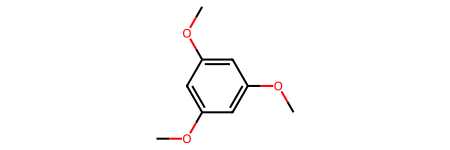

In [106]:
# Молекула для сравнения с молекулами из датасета
new_smile = 'COC1=CC(=CC(=C1)OC)OC'  # Ваш SMILES
mol = Chem.MolFromSmiles(new_smile)
mol

In [107]:
new_fingerprint = pyAvalonTools.GetAvalonCountFP(mol, nBits= 1024) # Получение fingerprint моей молекулы

In [108]:
tanimoto_scores = [] # Список с коэффициентами Танимото и соответствующим smiles молекулы.

for smiles in df_final['Smiles']:
    mol = Chem.MolFromSmiles(smiles)
    fingerprint = pyAvalonTools.GetAvalonCountFP(mol, nBits=1024)
    similarity = DataStructs.TanimotoSimilarity(new_fingerprint, fingerprint)
    tanimoto_scores.append((smiles, similarity))

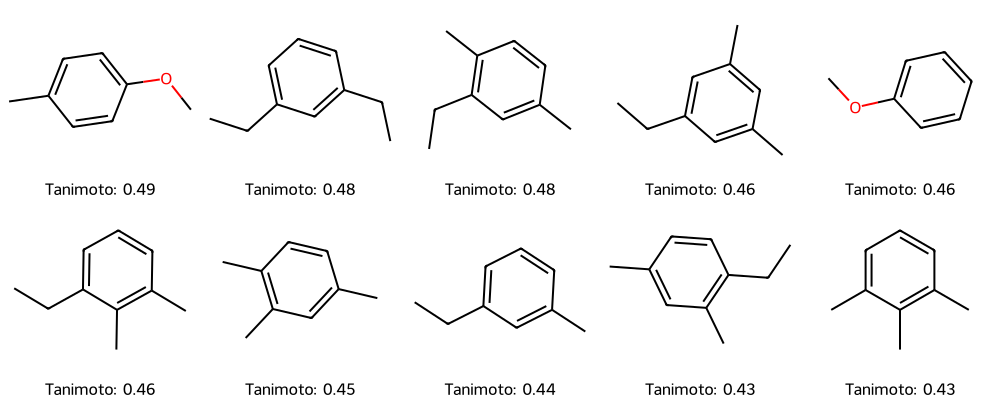

In [109]:
# Сортирует молекулы по коэффициенту Танимото
sorted_results = sorted(tanimoto_scores, key=lambda x: x[1],reverse=True)


# Создает список молекул и соответствующих им коэффициентов Танимото
sorted_mols = [Chem.MolFromSmiles(smiles) for smiles, score in sorted_results]
tanimoto_values = [score for smiles, score in sorted_results]

# Ограничение количества молекул для отображения до 10
limited_mols = sorted_mols[:10]

# Вывод структур молекул и коэффициентов Танимото, упорядоченных по убыванию Танимото
img = Draw.MolsToGridImage(limited_mols, molsPerRow=5, subImgSize=(200, 200), legends=[f'Tanimoto: {score:.2f}' for score in tanimoto_values[:20]])
display(img)



## Что можно улучшить?

* Автоматизировать сбор и очистку данных.
* Выбрать, возможно, более лучшие дескрипторы для моих молекул.
* Сделать анализ других моделей машинного обучения(Light GBM, XGBoost) / нейронных сетей (GCNN, MPNN).
* Сделать более углубленный анализ гиперпараметров моделей.